In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import kstest
from datetime import datetime, timedelta

1. Объединить данные из «Customer», «Prod_cat_info» и «Transactions» в единый датафрейм под названием customer_final. Проверить, что "сохранены" все клиенты, которые совершали транзакции

In [2]:
customer = pd.read_csv('customer.csv', sep=',')
customer.head(2)

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0


In [3]:
prod_cat_info = pd.read_csv('prod_cat_info.csv', sep=',')
prod_cat_info.head(2)

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women


In [4]:
transactions = pd.read_csv('transactions.csv', sep=',')
transactions.head(2)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop


In [5]:
# Проверяем первоначальное количество строк и уникальных пользователей в таблице
print('Количество строк:', transactions.shape[0])
print('Количество уникальных клиентов:', transactions['cust_id'].nunique())

Количество строк: 23053
Количество уникальных клиентов: 5506


In [6]:
# Проверяем общую информацию о датафрейме
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23053 non-null  int64  
 1   cust_id           23053 non-null  int64  
 2   tran_date         23053 non-null  object 
 3   prod_subcat_code  23053 non-null  int64  
 4   prod_cat_code     23053 non-null  int64  
 5   Qty               23053 non-null  int64  
 6   Rate              23053 non-null  int64  
 7   Tax               23053 non-null  float64
 8   total_amt         23053 non-null  float64
 9   Store_type        23053 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.8+ MB


In [7]:
# Объединяем 3 датафрейма в один
customer_final = transactions.rename(columns={'cust_id':'customer_Id', 'prod_subcat_code':'prod_sub_cat_code'}) \
                             .merge(prod_cat_info, how='left', on=['prod_sub_cat_code', 'prod_cat_code']) \
                             .merge(customer, how='left', on='customer_Id')

customer_final = customer_final.rename(columns=lambda col: col.lower()) # Приводим наименования всех столбцов к единому виду
customer_final = customer_final.rename(columns={'qty':'quantity', 'total_amt':'total_amount', 'prod_cat':'product_category', 
                                                'prod_subcat':'product_subcategory'})

customer_final.head(2)

,transaction_id,customer_id,tran_date,prod_sub_cat_code,prod_cat_code,quantity,rate,tax,total_amount,store_type,product_category,product_subcategory,dob,gender,city_code
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,Women,26-09-1981,M,5.0
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,Computers,11-05-1973,F,8.0


In [8]:
# Проверяем итоговую форму по кол-ву строк и клиентов
print('Количество строк:', customer_final.shape[0])
print('Количество уникальных клиентов:', customer_final.customer_id.nunique())

Количество строк: 23053
Количество уникальных клиентов: 5506


2. Составить сводный отчет для объединенного набора данных:
- Получить имена столбцов и соответствующие им типы данных
- Посмотреть на основные описательные статистики непрервных переменных
- Составить таблицы частот для всех категориальных переменных

In [9]:
customer_final.dtypes

transaction_id           int64
customer_id              int64
tran_date               object
prod_sub_cat_code        int64
prod_cat_code            int64
quantity                 int64
rate                     int64
tax                    float64
total_amount           float64
store_type              object
product_category        object
product_subcategory     object
dob                     object
gender                  object
city_code              float64
dtype: object

In [11]:
# Приводим столбцы к соответствующему типу данных
customer_final = customer_final.assign(tran_date=pd.to_datetime(customer_final.tran_date),
                                        dob=pd.to_datetime(customer_final.dob),
                                        store_type=pd.Categorical(customer_final.store_type),
                                        product_category=pd.Categorical(customer_final.product_category),
                                        product_subcategory=pd.Categorical(customer_final.product_subcategory),
                                        gender=pd.Categorical(customer_final.gender),
                                        city_code=pd.Categorical(customer_final.city_code));

In [12]:
# Посмотрим на распределение количественных переменных
customer_final[['quantity', 'rate', 'tax', 'total_amount']].describe()

,quantity,rate,tax,total_amount
count,23053.000000,23053.000000,23053.000000,23053.000000
mean,2.432395,636.369713,248.667192,2107.308002
std,2.268406,622.363498,187.177773,2507.561264
min,-5.000000,-1499.000000,7.350000,-8270.925000
25%,1.000000,312.000000,98.280000,762.450000
50%,3.000000,710.000000,199.080000,1754.740000
75%,4.000000,1109.000000,365.715000,3569.150000
max,5.000000,1500.000000,787.500000,8287.500000


In [13]:
# Далее посмотрим на содержимое категориальных переменных
customer_final.groupby('store_type').agg(count=('customer_id', 'count')).sort_values(by='count', ascending=False).reset_index()

,store_type,count
0,e-Shop,9311
1,MBR,4661
2,Flagship store,4577
3,TeleShop,4504


In [14]:
customer_final.groupby('product_category').agg(count=('customer_id', 'count')).sort_values(by='count', ascending=False).reset_index()

,product_category,count
0,Books,6069
1,Electronics,4898
2,Home and kitchen,4129
3,Footwear,2999
4,Clothing,2960
5,Bags,1998


In [15]:
customer_final.groupby('product_subcategory').agg(count=('customer_id', 'count')).sort_values(by='count', ascending=False).reset_index()

,product_subcategory,count
0,Women,3048
1,Mens,2912
2,Kids,1997
3,Tools,1062
4,Fiction,1043
5,Kitchen,1037
6,Children,1035
7,Comics,1031
8,Mobiles,1031
9,Bath,1023


In [16]:
customer_final.groupby('gender').agg(count=('customer_id', 'count')).sort_values(by='count', ascending=False).reset_index()

,gender,count
0,M,11811
1,F,11233


In [17]:
customer_final.groupby('city_code').agg(count=('customer_id', 'count')).sort_values(by='count', ascending=False).reset_index()

,city_code,count
0,4.0,2422
1,3.0,2411
2,5.0,2360
3,7.0,2356
4,10.0,2333
5,8.0,2330
6,2.0,2270
7,1.0,2258
8,9.0,2178
9,6.0,2127


На основе полученных данных можем заключить следующее. 

В данном розничном магазине в среднем клиенты покупает по 3 шт. товаров, но не более 5 штук за раз. Минимальное кол-во проданных штук имеет отрицательное значение - можем предположить, что таким образом отражены возвраты товаров. Средний чек составляет 2107 руб. Больше половины клиентов в основном совершают покупки на сумму не превышающую 3570 руб. При этом видим, что максимальная сумма дохода за 1 заказ составляла более 8000 руб. Данная сумма значительно отличается от нашей средней, из чего можем сделать вывод, чек в 8000 руб будем считать выбросом, также как и минимальный чек с суммой - 8270 руб.

Соотношение покупок сделанных мужчинами и женщинами различается незначительно (11811 против 11233, соответственно).  

Наибольшее количество товаров приобретается через Интернет-магазины (e-Shop). Наиболее популярные категории - Книги, Электроника и Товары для дома и кухни, а подкатегории - Товары для женщин, для мужчин и для детей. Остальные подкатегории различаются между собой незначительно.

Распределение по городам также похоже на равномерное и различается незначительно.

3. Сгенерировать гистограммы для основных числовых данных и барплоты для категориальных переменных.

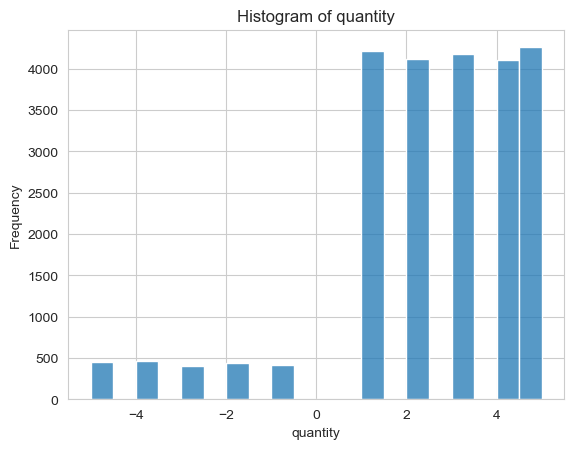

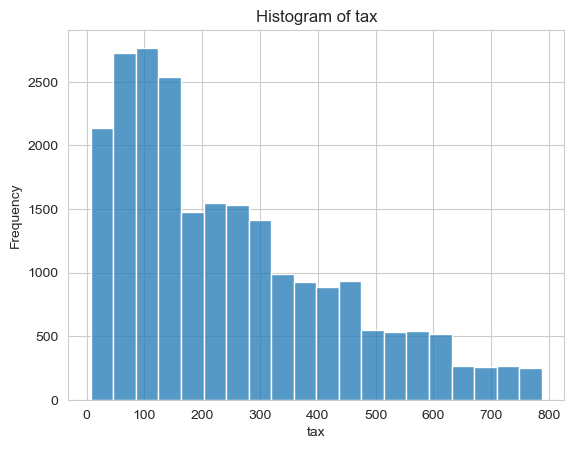

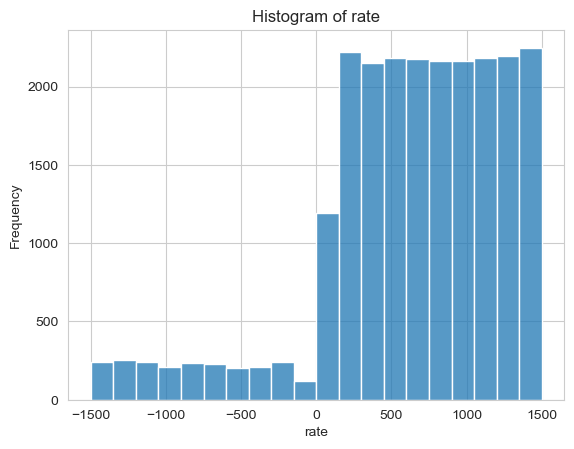

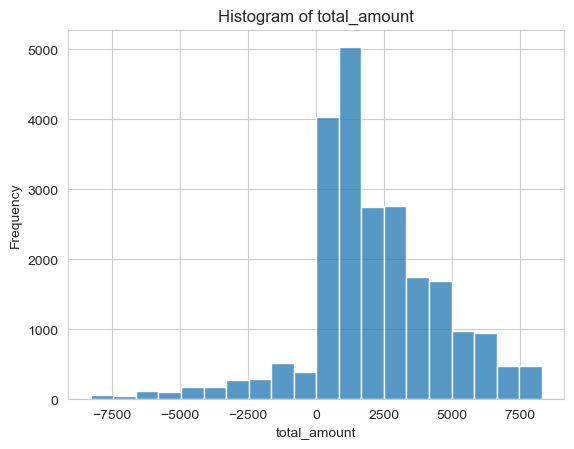

In [18]:
values = ['quantity', 'tax', 'rate', 'total_amount']

sns.set_style("whitegrid")

for value in values:
    sns.histplot(data=customer_final, x=value, bins=20)
    plt.xlabel(value)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {value}')
    plt.grid(True)
    plt.show()

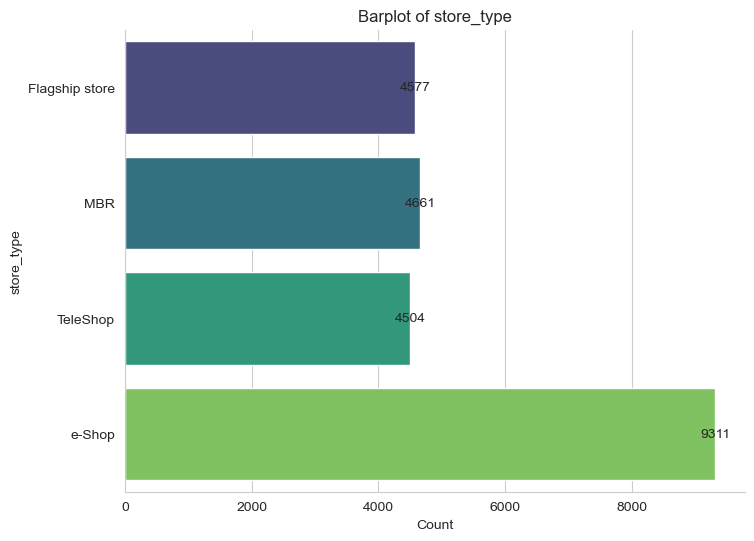

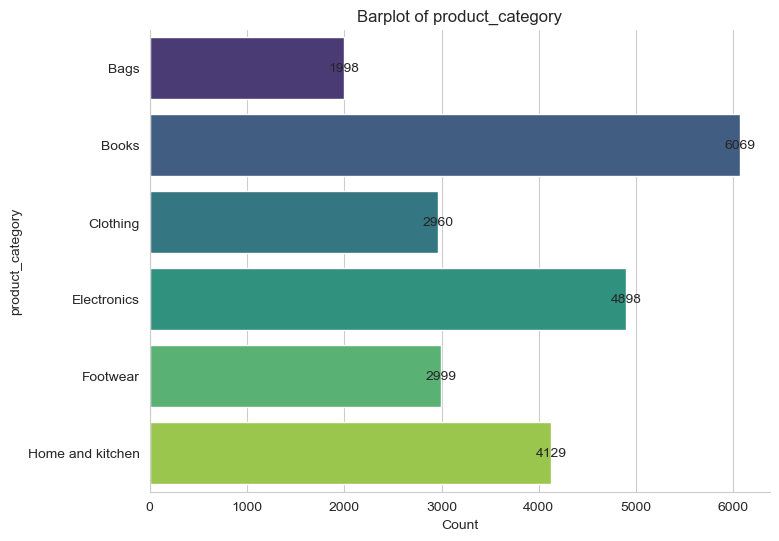

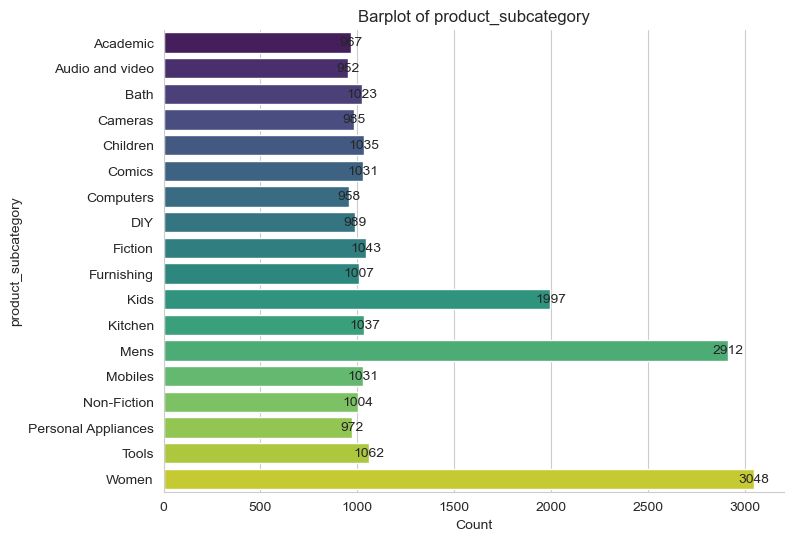

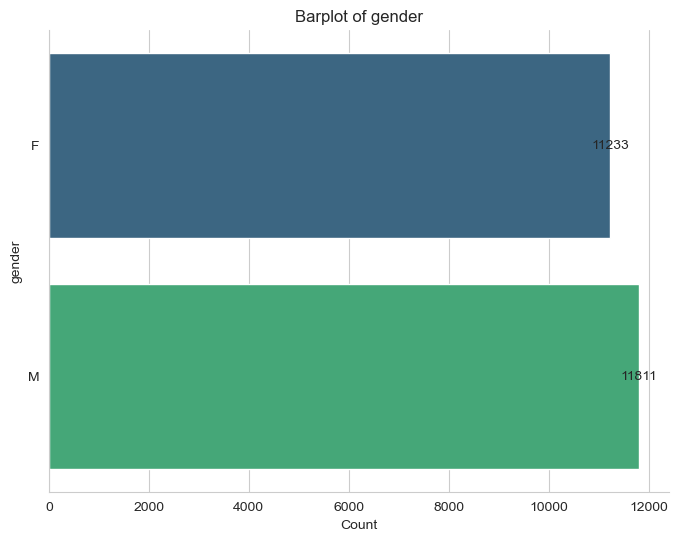

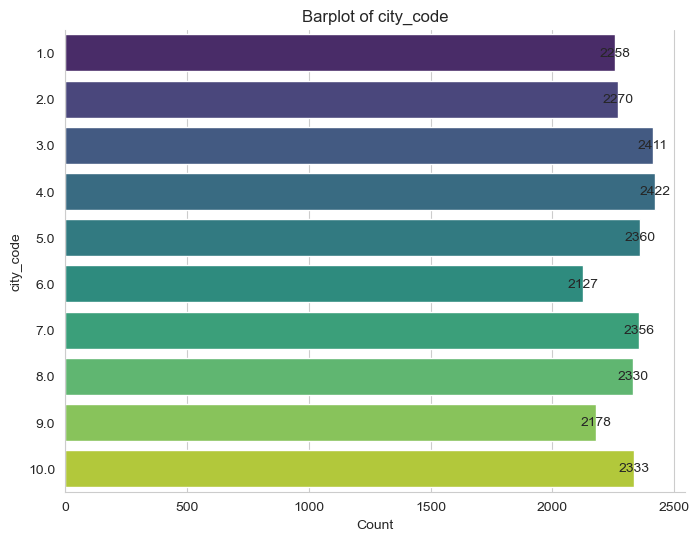

In [19]:
lists = ['store_type', 'product_category', 'product_subcategory', 'gender', 'city_code']

sns.set_style("whitegrid")

for value in lists:
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=customer_final[value].value_counts().reset_index(), y='index', x=value, palette='viridis')
    ax.set(ylabel=value, xlabel='Count')
    plt.title(f'Barplot of {value}')
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.0f}', (p.get_width() + 0.5, p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10)  # Добавляем аннотации с числом наблюдений
    
    sns.despine()
    plt.show()

Опеределить:

4.1. Доступный временной период в данных о транзакциях

4.2. Количество транзакций, в которых общая сумма транзакции была отрицательной

In [20]:
customer_final.tran_date.describe(datetime_is_numeric=True)

count                            23053
mean     2012-08-11 00:01:07.461935616
min                2011-01-02 00:00:00
25%                2011-10-31 00:00:00
50%                2012-08-12 00:00:00
75%                2013-05-18 00:00:00
max                2014-12-02 00:00:00
Name: tran_date, dtype: object

In [21]:
print(f'Данные отражены за период с {customer_final.tran_date.dt.date.min()} по {customer_final.tran_date.dt.date.max()}')
print(f'Количество транзакций с отрицательной суммой - {customer_final[customer_final["total_amount"] < 0].transaction_id.count()}')

Данные отражены за период с 2011-01-02 по 2014-12-02
Количество транзакций с отрицательной суммой - 2177


5. Проанализировать какие категории товаров более популярны среди женщин и мужчин

In [22]:
category = customer_final.groupby(['product_category', 'gender'])['customer_id'] \
                         .count().unstack() \
                         .sort_values(by=['F', 'M'], ascending=[False, False])
category

gender,F,M
product_category,,
Books,2949,3116
Electronics,2328,2570
Home and kitchen,1994,2134
Footwear,1529,1469
Clothing,1439,1518
Bags,994,1004


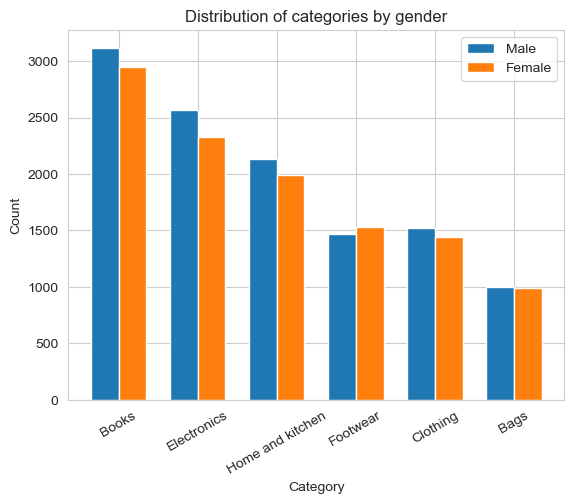

In [23]:
# Строим график покупок мужчин и женщин по различным категориям
fig, ax = plt.subplots()
bar_width = 0.35
bar_positions = range(len(category.index))
bar1 = ax.bar(bar_positions, category['M'], bar_width, label='Male')
bar2 = ax.bar([pos + bar_width for pos in bar_positions], category['F'], bar_width, label='Female')

ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Distribution of categories by gender')
ax.set_xticks([pos + bar_width/2 for pos in bar_positions])
plt.xticks(rotation=30)
ax.set_xticklabels(category.index)
ax.legend()

plt.show()

По графику мы видим, что колебания между двумя полами внутри разных категорий различаются достаточно слабо. С помощью критерия хи-квадрат проверим гипотезу о том, что между предпочтениями мужчин и женщин нет различий, т.е. вне зависимости от категории соотношение мужской категории к женской будет 50 на 50.

Итак, H0: M 50% = F 50%

In [24]:
# Построим таблицу сопряженности данных
ct_o = customer_final.groupby('gender')['product_category'].value_counts().unstack()
ct_o

,Bags,Books,Clothing,Electronics,Footwear,Home and kitchen
gender,,,,,,
F,994,2949,1439,2328,1529,1994
M,1004,3116,1518,2570,1469,2134


In [25]:
# Установим уровень значимости и определим степени свободы и критическое значение
alpha = 0.05
critical_value = 11.07
dof = (ct_o.shape[0] - 1) * (ct_o.shape[1] - 1)
dof

5

In [26]:
# Рассчитаем значение статистики хи-квадрат
chi_square = scipy.stats.chi2_contingency(ct_o, correction=True)
chi_square

(10.173309545156245,
 0.07047091620345859,
 5,
 array([[ 973.94263149, 2956.43746745, 1441.41559625, 2387.57307759,
         1461.40140601, 2012.22982121],
        [1024.05736851, 3108.56253255, 1515.58440375, 2510.42692241,
         1536.59859399, 2115.77017879]]))

In [27]:
chi_square[0] > critical_value

False

Расчетное значение хи-квадрат меньше критического, и значение p-value > 0.05, соответственно, у нас недостаточно оснований отклонить нулевую гипотезу о том, что соотношение полов составляет 50 на 50.

Таким образом, мы можем сказать, что наиболее популярные категории для обоих полов это: Книги, Электроника, Товары для дома и кухни. Однако также отметим, что численность мужчин в каждой категории немного больше, чем женщин.

In [28]:
# Проведем аналогичную проверку распределения полов для подкатегорий
subcategory = customer_final.groupby(['product_subcategory', 'gender'])['customer_id'] \
                            .count().unstack() \
                            .sort_values(by=['F', 'M'], ascending=[False, False])
subcategory

gender,F,M
product_subcategory,,
Women,1517,1529
Mens,1410,1502
Kids,1035,960
Academic,518,449
Tools,510,552
Bath,506,516
Kitchen,501,536
Non-Fiction,496,507
Fiction,485,557


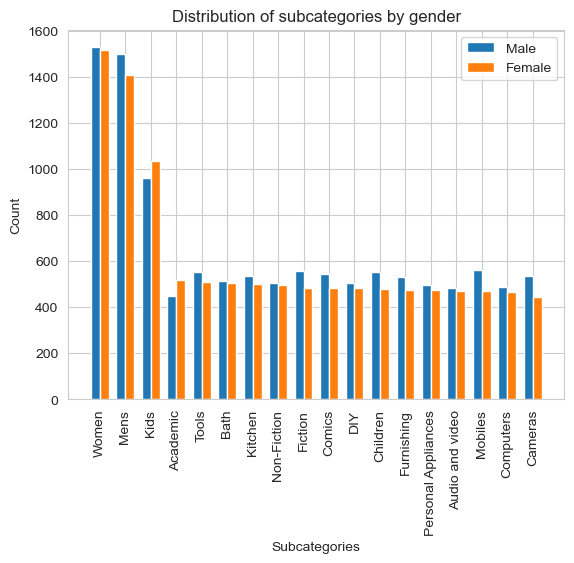

In [29]:
fig, ax = plt.subplots()
bar_width = 0.35
bar_positions = range(len(subcategory.index)) #  Создаем последовательность позиций для столбцов на графике
bar1 = ax.bar(bar_positions, subcategory['M'], bar_width, label='Male') # Строим первый набор столбцов для мужчин ('M') 
bar2 = ax.bar([pos + bar_width for pos in bar_positions], subcategory['F'], bar_width, label='Female') # Строим такой же набор данных для женщин ('F')

ax.set_xlabel('Subcategories')
ax.set_ylabel('Count')
ax.set_title('Distribution of subcategories by gender')
ax.set_xticks([pos + bar_width/2 for pos in bar_positions]) # Устанавливаем метки на оси x в середине каждого столбца
plt.xticks(rotation=90)
ax.set_xticklabels(subcategory.index) # Устанавливаем наименования категорий на оси x
ax.legend()

plt.show()

In [30]:
# Построим таблицу сопряженности для подкатегорий
ct_o_subcat = customer_final.groupby('gender')['product_subcategory'].value_counts().unstack()
ct_o_subcat

,Academic,Audio and video,Bath,Cameras,Children,Comics,Computers,DIY,Fiction,Furnishing,Kids,Kitchen,Mens,Mobiles,Non-Fiction,Personal Appliances,Tools,Women
gender,,,,,,,,,,,,,,,,,,
F,518,470,506,447,481,485,468,484,485,477,1035,501,1410,469,496,474,510,1517
M,449,482,516,538,553,546,490,504,557,530,960,536,1502,562,507,498,552,1529


In [31]:
# Установим уровень значимости и определим степени свободы и критическое значение
alpha = 0.05
critical_value_sub = 27.587
dof = (ct_o_subcat.shape[0] - 1) * (ct_o_subcat.shape[1] - 1)
dof

17

In [32]:
# Рассчитаем значение статистики хи-квадрат
chi_square_sub = scipy.stats.chi2_contingency(ct_o_subcat, correction=True)
chi_square_sub

(34.11865368761099,
 0.008104895635552304,
 17,
 array([[ 471.37263496,  464.06075334,  498.18286756,  480.1468929 ,
          504.03237285,  502.56999653,  466.98550599,  481.60926922,
          507.93204305,  490.87098594,  972.48025516,  505.49474918,
         1419.4799514 ,  502.56999653,  488.92115084,  473.80992883,
          517.68121854, 1484.79942718],
        [ 495.62736504,  487.93924666,  523.81713244,  504.8531071 ,
          529.96762715,  528.43000347,  491.01449401,  506.39073078,
          534.06795695,  516.12901406, 1022.51974484,  531.50525082,
         1492.5200486 ,  528.43000347,  514.07884916,  498.19007117,
          544.31878146, 1561.20057282]]))

In [33]:
chi_square_sub[0] > critical_value_sub

True

Значение хи-квадрат оказалось больше критического значения и p-value < 0.05, соответственно мы можем отклонить нулевую гипотезу о равном соотношении полов в подкатегориях.

Тем не менее по графику мы видим, что наиболее популярные подкатегории для обоих - Женщины, Мужчины, Дети. Но соотношение мужчин и женщин внутри данных подкатегорий различаются уже значительно.

6. Определить в каком городе (коде города) наибольшее количество клиентов и процент клиентов из этого города?

In [34]:
city_customers = customer_final.groupby('city_code').agg(customer_count=('customer_id', 'count')).reset_index()

city_customers['city_persent'] = round(city_customers.customer_count / city_customers.customer_count.sum() * 100, 2)

city_customers

,city_code,customer_count,city_persent
0,1.0,2258,9.80
1,2.0,2270,9.85
2,3.0,2411,10.46
3,4.0,2422,10.51
4,5.0,2360,10.24
5,6.0,2127,9.23
6,7.0,2356,10.22
7,8.0,2330,10.11
8,9.0,2178,9.45
9,10.0,2333,10.12


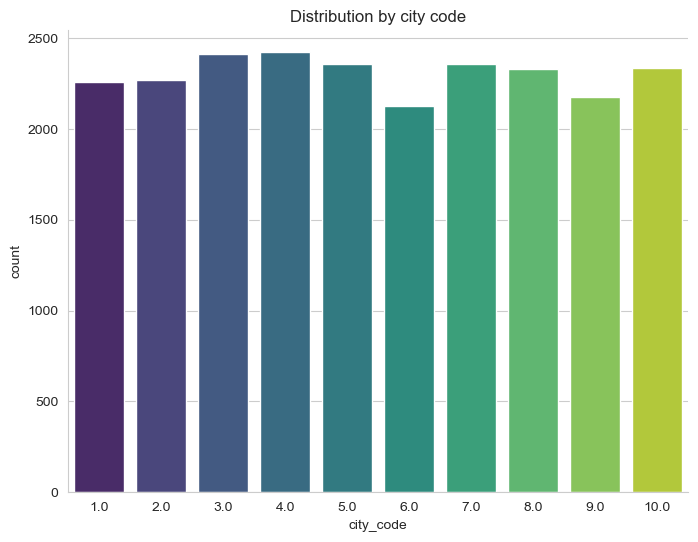

In [35]:
plt.figure(figsize=(8, 6))  # Задаем размер графика
ax = sns.barplot(data=city_customers, y='customer_count', x='city_code', palette='viridis')
ax.set(ylabel='count', xlabel='city_code')  # Подписываем оси
plt.title('Distribution by city code')
    
sns.despine()
plt.show()

In [36]:
# Находим максимальный процент
max_customer = city_customers.city_persent.idxmax()

# Выводим строку с наибольшим кол-вом клиентов
print(city_customers.loc[max_customer])

city_code            4.00
customer_count    2422.00
city_persent        10.51
Name: 3, dtype: float64


7. Какой тип магазина продает максимальное количество товаров по стоимости и количеству?

In [37]:
store_type = customer_final.groupby('store_type', as_index=False) \
                            .agg(quantity=('quantity', 'sum'), 
                                 revenue=('total_amount', 'sum')) \
                            .round(2)

# Находим индексы максимальных значений по колонкам quantity и revenue
max_quantity_index = store_type['quantity'].idxmax()
max_revenue_index = store_type['revenue'].idxmax()

# Выводим строки с максимальными значениями
print(store_type.loc[[max_quantity_index, max_revenue_index]])

  store_type  quantity      revenue
3     e-Shop     22763  19824816.05
3     e-Shop     22763  19824816.05


E-Shop продает наибольшее число товаров и по количеству, и по стоимости

8. Определить общую сумму доходов по категориям «Электроника» и «Одежда» от Флагманских магазинов.

In [38]:
flagship_revenue = customer_final[(customer_final['store_type'] == 'Flagship store')] \
                    .query('product_category == "Electronics" | product_category == "Clothing"') \
                    .groupby('product_category') \
                    .agg({'total_amount':'sum'}) \
                    .query('total_amount > 0') \
                    .reset_index()
flagship_revenue

,product_category,total_amount
0,Clothing,1194423.23
1,Electronics,2215136.04


9. Определить общую сумму доходов от мужчин-клиентов в категории «Электроника»?

In [39]:
male_revenue = customer_final[(customer_final['gender'] == 'M')] \
                    .groupby('product_category', as_index=False) \
                    .agg({'total_amount':'sum'}) \
                    .query('product_category == "Electronics"')
male_revenue

,product_category,total_amount
3,Electronics,5703109.425


10. Сколько клиентов имеют более 10 уникальных транзакций (без учета отрицательных транзакций)?

In [40]:
# Определим клиентов, с отрицательной выручкой
negative_amount = customer_final[customer_final['total_amount'] < 0].customer_id.unique()

In [41]:
# С помощью инверсии определим необходимых по условию клиентов (выбираем всех клиентов, где id НЕ находятся в списке negative_amount)
customer_final[~customer_final['customer_id'].isin(negative_amount)].groupby('customer_id') \
                                             .agg(cnt_transactions = ('transaction_id','count')) \
                                             .query('cnt_transactions > 10') \
                                             .reset_index()

,customer_id,cnt_transactions
0,270535,11
1,270803,11
2,272741,11


Проверим какое количество клиентов совершали продажи на протяжении всех лет

In [42]:
# Выбираем данные для каждого года
data_2011 = customer_final.query('(tran_date >= "2011-01-01") & (tran_date <= "2012-12-31")').groupby('customer_id').transaction_id.count()
data_2012 = customer_final.query('(tran_date >= "2012-01-01") & (tran_date <= "2013-12-31")').groupby('customer_id').transaction_id.count()
data_2013 = customer_final.query('(tran_date >= "2013-01-01") & (tran_date <= "2014-12-31")').groupby('customer_id').transaction_id.count()

# Объединяем данные по клиентам и находим пересечения
common_customers = set(data_2011.index) & set(data_2012.index) & set(data_2013.index)

# Подсчитываем общее количество клиентов
total_customers = len(common_customers)
total_customers

3783

11. Определить для всех клиентов в возрасте от 25 до 35 лет: 
    
    11.1. Общую сумму расходов по категориям «Электроника» и «Книги» 
    
    11.2. Общую сумму расходов для данной категории клиентов за период с 1 января 2014 г. по 1 марта 2014 г.?

In [43]:
# Добавим в датафрейм расчетный столбец с возрастом клиентов
customer_final['age'] = (pd.to_datetime('today') - customer_final['dob']).dt.days // 365

In [44]:
total_cost_for_category = customer_final.query('age >= 25 & age <= 35') \
                                 .groupby('product_category') \
                                 .agg({'total_amount':'sum'}) \
                                 .query('product_category == "Electronics" | product_category == "Books"') \
                                 .reset_index()
total_cost_for_category

,product_category,total_amount
0,Books,2591081.35
1,Electronics,2216119.49


In [45]:
total_cost_for_period = customer_final.query('(age >= 25 & age <= 35) \
                                             &(tran_date >= "2014-01-01") \
                                             &(tran_date <= "2014-03-01")')['total_amount'].sum().round(2)
total_cost_for_period

370336.33

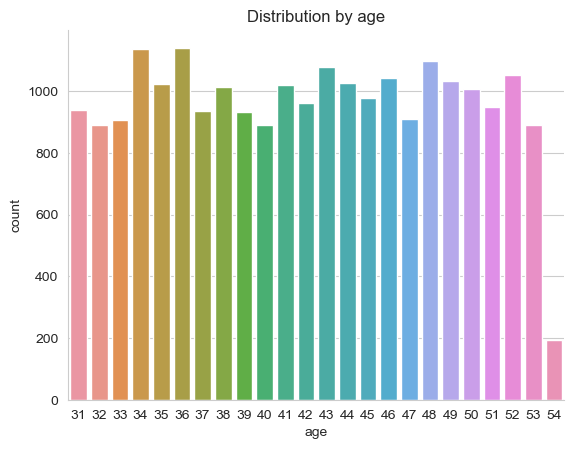

In [46]:
ax = sns.barplot(data=customer_final.groupby('age').customer_id.count().reset_index(), x='age', y='customer_id')
ax.set(ylabel='count', xlabel='age')
plt.title('Distribution by age')
    
sns.despine()
plt.show()

По результатам анализа данных могу сделать следующие выводы.

Анализировались данные по продажам в ритейле за период с 2011-01-02 по 2014-12-02. За это время было произведено более 23000 транзакций для 5506 уникальных клиентов. Средний чек составляет 2107 руб., медианное значение 1754 руб. Показатели различаются значительно, это говорит о наличии в данных выбросов, которые смещают среднюю (в данном случае, транзакции с отрицательной суммой уменьшают нашу выручку). Это также подтверждается min и max значениями по колонке с total_amount (-8270 и 8287, соответственно).

Среднее количество товаров в одном чеке - 2, медианное - 3. Данные схожи, разницу опять же можем объяснить наличием аномалии с отрицательными значениями и широкий разброс (наименьшее значение -5, наибольшее 5).

В структуре данных представлено 4 типа магазинов. Самый крупный из них по количеству продаж - e-Shop, типы MBR, Flagship store и TeleShop представлены примерно в равном количестве. Соотношение мужской и женской аудитории различается незначительно (но покупателей-мужчин больше на 2,5%). e-Shop лидирует также и по количеству продаваемых товаров (22,763 шт против ~ 11,000 по каждому из оставшихся типов магазинов) и по выручке (19,8 млн денежных единиц против ~ 9,3 млн по каждому из магазинов).

По категориям товаров самые частопродаваемые категории - Книги (пользуются одинаково большой популярностью у обоих полов), Элекроника и Товары для дома и кухни. На основании анализа хи-квадрат было установлено, что колебания между разными гендерами внутри данных групп различаются незначительно, и можно говорить о сохранении пропорции в 50/50 (М/Ж).

Среди подкатегорий наиболее популярны - Women, Mens, Kids. Однако на основе того же исследования хи-квадрат в этом случае, мы уже не можем говорить о том, что соотношение мужчин и женщин в них одинаковое (гипотеза о равном соотношении была отклонена).

Распределении клиентов по городам (интерпретирую это через данные по city_code) имеет схожие значения, ~ по 10% на каждый город. Таким образом привлечение клиентов осуществляется без явного преимущества по какому-то городу, и можно сделать вывод о корректно определенной целевой аудитории, так как спрос на продукцию одинаковый.

Не менее 90% всех клиентов совершали, как минимум, одну повторную покупку (5043 чел.), более 5 раз покупку совершили 25% (1393 чел.) пользователей, и более 10 - 0,65% (36 чел.). При этом помним, что это данные за 4 года (с 2011 по 2014). В исходных файлах нет информации о том, данные по какой(им) стране(ам) приведены, но отмечу, что даже для того периода времени и с учетом того, что еще не случился рост популярности онлайн-продаж, показатели крайне малы. Предположу, что это данные по совсем небольшому ритейлу, где есть постоянные покупатели, которые совершают по несколько (до 5) продаж в год: кол-во клиентов совершавших покупки из года в год - 3783 чел.

Текущий возраст аудитории ритейла 31+, и совсем отсутствуют школьники, студенты, "молодежь". Но, опять же можем списать это на погрешность расчетов, т.к. возраст вычислялся от текущей даты (2024 год) и сами данные достаточно старые, за вычетом разницы между текущей датой и датой последней транзакции мы получим молодую аудиторию (20+), которая периодически совершала продажи в данном ритейле в период с 2011 по 2014 гг.